In [1]:
import spacetimeformer as stf
import pytorch_lightning as pl
import numpy as np
from scipy.stats import chi2, norm, beta, gamma
import matplotlib.pyplot as plt
import math
import pandas as pd

In [5]:
default_config = {
    # fixed but maybe change...
    'batch_size': 2000,
    'workers': 6,
    'init_lr': 1e-10,
    'base_lr': 0.0005,
    'context_points': 32,
    'target_points': 1,
    'd_model': 100,
    'd_qk': 100,
    'd_v': 100,
    'd_ff': 400,
    'n_heads': 1,
    'enc_layers': 1,
    'dec_layers': 1,
    'global_self_attn': 'full',
    'local_self_attn': 'full',
    'global_cross_attn': 'full',
    'local_cross_attn': 'full',
    'no_val': False,
    'no_time': False,
    'no_space': False,
    'no_given': False,

    # directly set parameters
    'gpus': [0],
    # 'gpus':None,
    'strategy': 'dp',
    "time_resolution": 1,
    "start_token_len": 0,
    "attn_factor": 5,
    "dropout_emb": 0.2,
    "dropout_attn_out": 0,
    "dropout_attn_matrix": 0,
    "dropout_qkv": 0,
    "dropout_ff": 0.3,
    "pos_emb_type": 'abs',
    "no_final_norm": False,
    "performer_kernel": 'relu',
    "performer_redraw_interval": 100,
    "attn_time_windows": 1,
    "use_shifted_time_windows": False,
    "norm": 'batch',
    "activation": 'gelu',
    "warmup_steps": 0,
    "decay_factor": 0.25,
    "initial_downsample_convs": 0,
    "intermediate_downsample_convs": 0,
    "embed_method": 'spatio-temporal',
    "l2_coeff": 0.000001,
    "loss": 'mse',
    "class_loss_imp": 0.1,
    "recon_loss_imp": 0,
    "time_emb_dim": 3,
    "null_value": None,
    "pad_value": None,
    "linear_window": 0,
    "use_revin": False,
    "linear_shared_weights": False,
    "use_seasonal_decomp": False,
    "recon_mask_skip_all": 1,
    "recon_mask_max_seq_len": 5,
    "recon_mask_drop_seq": 0.2,
    "recon_mask_drop_standard": 0.1,
    "recon_mask_drop_full": 0.05,
    "grad_clip_norm": 0.0,
    "accumulate": 1,
    "limit_val_batches": 1.0,
    "max_epochs": 10,
    "val_check_interval": 1.0,
}

def create_model(config, x_dim, yc_dim, yt_dim):
    max_seq_len = config['context_points'] + config['target_points']

    forecaster = stf.spacetimeformer_model.Spacetimeformer_Forecaster(
        d_x=x_dim,
        d_yc=yc_dim,
        d_yt=yt_dim,
        max_seq_len=max_seq_len,
        start_token_len=config['start_token_len'],
        attn_factor=config['attn_factor'],
        d_model=config['d_model'],
        d_queries_keys=config['d_qk'],
        d_values=config['d_v'],
        n_heads=config['n_heads'],
        e_layers=config['enc_layers'],
        d_layers=config['dec_layers'],
        d_ff=config['d_ff'],
        dropout_emb=config['dropout_emb'],
        dropout_attn_out=config['dropout_attn_out'],
        dropout_attn_matrix=config['dropout_attn_matrix'],
        dropout_qkv=config['dropout_qkv'],
        dropout_ff=config['dropout_ff'],
        pos_emb_type=config['pos_emb_type'],
        use_final_norm=not config['no_final_norm'],
        global_self_attn=config['global_self_attn'],
        local_self_attn=config['local_self_attn'],
        global_cross_attn=config['global_cross_attn'],
        local_cross_attn=config['local_cross_attn'],
        performer_kernel=config['performer_kernel'],
        performer_redraw_interval=config['performer_redraw_interval'],
        attn_time_windows=config['attn_time_windows'],
        use_shifted_time_windows=config['use_shifted_time_windows'],
        norm=config['norm'],
        activation=config['activation'],
        init_lr=config['init_lr'],
        base_lr=config['base_lr'],
        warmup_steps=config['warmup_steps'],
        decay_factor=config['decay_factor'],
        initial_downsample_convs=config['initial_downsample_convs'],
        intermediate_downsample_convs=config['intermediate_downsample_convs'],
        embed_method=config['embed_method'],
        l2_coeff=config['l2_coeff'],
        loss=config['loss'],
        class_loss_imp=config['class_loss_imp'],
        recon_loss_imp=config['recon_loss_imp'],
        time_emb_dim=config['time_emb_dim'],
        null_value=config['null_value'],
        pad_value=config['pad_value'],
        linear_window=config['linear_window'],
        use_revin=config['use_revin'],
        linear_shared_weights=config['linear_shared_weights'],
        use_seasonal_decomp=config['use_seasonal_decomp'],
        use_val=not config['no_val'],
        use_time=not config['no_time'],
        use_space=not config['no_space'],
        use_given=not config['no_given'],
        recon_mask_skip_all=config['recon_mask_skip_all'],
        recon_mask_max_seq_len=config['recon_mask_max_seq_len'],
        recon_mask_drop_seq=config['recon_mask_drop_seq'],
        recon_mask_drop_standard=config['recon_mask_drop_standard'],
        recon_mask_drop_full=config['recon_mask_drop_full'],
    )
    return forecaster

def s1_data(config, m=1):
    fs = 2048  # Sampling rate (Hz)
    T = 150  # Length of epochs (s)

    # Set the seed for reproducibility
    np.random.seed(0)

    # Define the number of iterations for the simulation
    n_iterations = fs * T
    # Preallocate the arrays for the x variables
    x1 = np.zeros(n_iterations)
    x2 = np.zeros(n_iterations)
    x3 = np.zeros(n_iterations)
    x4 = np.zeros(n_iterations)
    x5 = np.zeros(n_iterations)

    # Define the rate lambda for the exponential distribution
    lambda_rate = 2

    # Generate the noise processes e1t, e2t, e3t, e4t, e5t
    e1 = np.random.exponential(scale=1 / lambda_rate, size=n_iterations)
    e2 = chi2.rvs(df=1, size=n_iterations)
    e3 = norm.rvs(scale=1, size=n_iterations) *m # Gaussian with mean 0, std 1
    e4 = norm.rvs(scale=1, size=n_iterations) *m # Gaussian with mean 0, std 1
    e5 = norm.rvs(scale=1, size=n_iterations) *m# Gaussian with mean 0, std 1

    for t in range(0, n_iterations):
        # Generate the x variables based on the given equations
        x1[t] = e1[t]
        x2[t] = e2[t]
        x3[t] = 0.8 * x2[t] + e3[t]
        x4[t] = 0.7 * x1[t] * (math.pow(x1[t], 2) - 1) * np.exp((-math.pow(x1[t], 2)) / 2) + e4[t]
        x5[t] = 0.3 * x2[t] + 0.05 * math.pow(x2[t], 2) + e5[t]

    # After the loop, x1t, x2t, x3t, x4t, and x5t contain the simulation data.

    PLOT_VAR_NAMES = np.arange(5) + 1
    PLOT_VAR_IDXS = np.arange(5)

    data = np.array([x1, x2, x3, x4, x5]).T

    df = pd.DataFrame(data, columns=PLOT_VAR_NAMES)
    df["Datetime"] = pd.date_range(start="1/1/2020", periods=df.shape[0], freq="ms")

    dset = stf.data.CSVTimeSeries(
        data_path=None,
        raw_df=df,
        val_split=0.1,
        test_split=0.1,
        normalize=True,
        time_col_name="Datetime",
        time_features=["minute", 'second', 'millisecond'],
    )
    yc_dim = data.shape[1]
    yt_dim = data.shape[1]
    x_dim = dset.time_cols.shape[0]

    DATA_MODULE = stf.data.DataModule(
        datasetCls=stf.data.CSVTorchDset,
        dataset_kwargs={
            "csv_time_series": dset,
            "context_points": config['context_points'],
            "target_points": config['target_points'],
            "time_resolution": config['time_resolution'],
        },
        batch_size=config['batch_size'],
        workers=config['workers'],
        overfit=False,
    )
    INV_SCALER = dset.reverse_scaling
    SCALER = dset.apply_scaling
    NULL_VAL = None
    return DATA_MODULE

def s2_data(config):
    fs = 2048  # Sampling rate (Hz)
    T = 150  # Length of epochs (s)

    # Set the seed for reproducibility
    np.random.seed(0)

    # Define the number of iterations for the simulation
    n_iterations = fs * T

    # Preallocate the arrays for the x variables
    x1 = np.zeros(n_iterations)
    x2 = np.zeros(n_iterations)
    x3 = np.zeros(n_iterations)
    x4 = np.zeros(n_iterations)
    x5 = np.zeros(n_iterations)

    # Define the rate lambda for the exponential distribution
    lambda_rate = 2

    # Generate the noise processes e1t, e2t, e3t, e4t, e5t
    e1 = norm.rvs(scale=1, size=n_iterations)  # Gaussian with mean 0, std 1
    e2 = np.random.exponential(scale=1 / lambda_rate, size=n_iterations)
    e3 = beta.rvs(a=1, b=2, size=n_iterations)
    e4 = beta.rvs(a=2, b=1, size=n_iterations)
    e5 = norm.rvs(scale=1, size=n_iterations)  # Gaussian with mean 0, std 1

    for t in range(3, n_iterations):
        # Generate the x variables based on the given equations
        x1[t] = 0.7 * x1[t - 1] + e1[t]
        x2[t] = 0.3 * np.power(x1[t - 2], 2) + e2[t]
        x3[t] = 0.4 * x1[t - 3] - 0.3 * x3[t - 2] + e3[t]
        x4[t] = 0.7 * x4[t - 1] - 0.3 * x5[t - 1] * np.exp((-math.pow(x5[t - 1], 2)) / 2) + e4[t]
        x5[t] = 0.5 * x4[t - 1] + 0.2 * x5[t - 2] + e5[t]

    data = np.array([x1, x2, x3, x4, x5]).T
    PLOT_VAR_NAMES = np.arange(5) + 1
    PLOT_VAR_IDXS = np.arange(5)
    df = pd.DataFrame(data, columns=PLOT_VAR_NAMES)
    df["Datetime"] = pd.date_range(start="1/1/2020", periods=df.shape[0], freq="ms")

    dset = stf.data.CSVTimeSeries(
        data_path=None,
        raw_df=df,
        val_split=0.2,
        test_split=0.2,
        normalize=True,
        time_col_name="Datetime",
        time_features=["minute", 'second', 'millisecond'],
    )
    yc_dim = data.shape[1]
    yt_dim = data.shape[1]
    x_dim = dset.time_cols.shape[0]

    DATA_MODULE = stf.data.DataModule(
        datasetCls=stf.data.CSVTorchDset,
        dataset_kwargs={
            "csv_time_series": dset,
            "context_points": config['context_points'],
            "target_points": config['target_points'],
            "time_resolution": config['time_resolution'],
        },
        batch_size=config['batch_size'],
        workers=config['workers'],
        overfit=False,
    )

    return DATA_MODULE

def ar_data(config, m=1):
    fs = 2048  # Sampling rate (Hz)
    T = 150  # Length of epochs (s)

    # Set the seed for reproducibility
    np.random.seed(42)

    # Define the number of iterations for the simulation
    n_iterations = fs * T
    # Preallocate the arrays for the x variables
    x1 = np.zeros(n_iterations)
    x2 = np.zeros(n_iterations)
    x3 = np.zeros(n_iterations)
    x4 = np.zeros(n_iterations)
    x5 = np.zeros(n_iterations)

    # Define the rate lambda for the exponential distribution
    lambda_rate = 2

    # Generate the noise processes e1t, e2t, e3t, e4t, e5t
    e1 = np.random.exponential(scale=1 / lambda_rate, size=n_iterations)
    e2 = chi2.rvs(df=1, size=n_iterations)
    # e1 = norm.rvs(scale=1, size=n_iterations)
    # e2 = norm.rvs(scale=1, size=n_iterations)
    e3 = norm.rvs(scale=1, size=n_iterations) *m # Gaussian with mean 0, std 1
    e4 = norm.rvs(scale=1, size=n_iterations) *m # Gaussian with mean 0, std 1
    e5 = norm.rvs(scale=1, size=n_iterations) *m# Gaussian with mean 0, std 1

    for t in range(6, n_iterations):
        # Generate the x variables based on the given equations
        x1[t] = 0.05 * x1[t-5] - 0.15 * x1[t-4] + 0.25 * x1[t-3] - 0.35 * x1[t-2] + 0.45 * x1[t-1] + e1[t]
        # x1[t] = e1[t]

        x2[t] = - 0.01 * x2[t-6] + .09 * x2[t-5] - 0.2 * x2[t-4] + .27 * x2[t-3] - 0.35 * x2[t-2] + .4 * x2[t-1] + e2[t]
        x3[t] = 0.8 * x2[t] + e3[t]
        x4[t] = 0.7 * x1[t] * (math.pow(x1[t], 2) - 1) * np.exp((-math.pow(x1[t], 2)) / 2) + e4[t]
        x5[t] = 0.3 * x2[t] + 0.05 * math.pow(x2[t], 2) + e5[t]

    # After the loop, x1t, x2t, x3t, x4t, and x5t contain the simulation data.

    PLOT_VAR_NAMES = np.arange(5) + 1
    PLOT_VAR_IDXS = np.arange(5)

    data = np.array([x1, x2, x3, x4, x5]).T
    data= data[100:]
    df = pd.DataFrame(data, columns=PLOT_VAR_NAMES)

    df["Datetime"] = pd.date_range(start="1/1/2020", periods=df.shape[0], freq="s")

    dset = stf.data.CSVTimeSeries(
        data_path=None,
        raw_df=df,
        val_split=0.1,
        test_split=0.1,
        normalize=True,
        time_col_name="Datetime",
        time_features=["hour", 'minute', 'second'],
    )
    yc_dim = data.shape[1]
    yt_dim = data.shape[1]
    x_dim = dset.time_cols.shape[0]

    DATA_MODULE = stf.data.DataModule(
        datasetCls=stf.data.CSVTorchDset,
        dataset_kwargs={
            "csv_time_series": dset,
            "context_points": config['context_points'],
            "target_points": config['target_points'],
            "time_resolution": config['time_resolution'],
        },
        batch_size=config['batch_size'],
        workers=config['workers'],
        overfit=False,
    )
    INV_SCALER = dset.reverse_scaling
    SCALER = dset.apply_scaling
    NULL_VAL = None

    return DATA_MODULE

trainer = pl.Trainer(
        gpus=default_config['gpus'],
        callbacks=[],

        accelerator="dp",
        gradient_clip_val=default_config['grad_clip_norm'],
        gradient_clip_algorithm="norm",
        overfit_batches= 0,
        accumulate_grad_batches=default_config['accumulate'],
        sync_batchnorm=False,
        limit_val_batches=default_config['limit_val_batches'],
        max_epochs=default_config['max_epochs'],
        log_every_n_steps=1,
        val_check_interval = default_config['val_check_interval'],
    )


/home/wendeldr/miniconda3/envs/spacetimeformer/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:287: LightningDeprecationWarning: Passing `Trainer(accelerator='dp')` has been deprecated in v1.5 and will be removed in v1.7. Use `Trainer(strategy='dp')` instead.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..


In [6]:
path = "/home/wendeldr/git/spacetimeformer/spacetimeformer/data/STF_LOG_DIR/F_S1_1_m0_b82d547a/F_S1_1_m0epoch=27.ckpt"

In [7]:
data_module = ar_data(default_config)

In [8]:
model = create_model(default_config, 3, 5, 5)
model.set_inv_scaler(data_module.dataset_kwargs['csv_time_series'].reverse_scaling)
model.set_scaler(data_module.dataset_kwargs['csv_time_series'].apply_scaling)
model.set_null_value(None)
model = model.load_from_checkpoint(path)
model.to("cuda")

Forecaster
	L2: 1e-06
	Linear Window: 0
	Linear Shared Weights: False
	RevIN: False
	Decomposition: False
GlobalSelfAttn: AttentionLayer(
  (inner_attention): FullAttention(
    (dropout): Dropout(p=0, inplace=False)
  )
  (query_projection): Linear(in_features=100, out_features=100, bias=True)
  (key_projection): Linear(in_features=100, out_features=100, bias=True)
  (value_projection): Linear(in_features=100, out_features=100, bias=True)
  (out_projection): Linear(in_features=100, out_features=100, bias=True)
  (dropout_qkv): Dropout(p=0, inplace=False)
)
GlobalCrossAttn: AttentionLayer(
  (inner_attention): FullAttention(
    (dropout): Dropout(p=0, inplace=False)
  )
  (query_projection): Linear(in_features=100, out_features=100, bias=True)
  (key_projection): Linear(in_features=100, out_features=100, bias=True)
  (value_projection): Linear(in_features=100, out_features=100, bias=True)
  (out_projection): Linear(in_features=100, out_features=100, bias=True)
  (dropout_qkv): Dropout

Spacetimeformer_Forecaster(
  (spacetimeformer): Spacetimeformer(
    (enc_embedding): Embedding(
      (data_drop): Timesteps 0.05, Standard 0.1, Seq (max len = 5) 0.2, Skip All Drop 1.0
      (time_emb): Time2Vec()
      (local_emb): Embedding(33, 100)
      (val_time_emb): Linear(in_features=19, out_features=100, bias=True)
      (space_emb): Embedding(5, 100)
      (given_emb): Embedding(2, 100)
      (downsize_convs): ModuleList()
    )
    (dec_embedding): Embedding(
      (time_emb): Time2Vec()
      (local_emb): Embedding(33, 100)
      (val_time_emb): Linear(in_features=19, out_features=100, bias=True)
      (space_emb): Embedding(5, 100)
      (given_emb): Embedding(2, 100)
      (downsize_convs): ModuleList()
    )
    (encoder): Encoder(
      (attn_layers): ModuleList(
        (0): EncoderLayer(
          (local_attention): AttentionLayer(
            (inner_attention): FullAttention(
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (query_p

In [9]:
test_samples = next(iter(data_module.test_dataloader()))
xc, yc, xt, y_true = test_samples
b = yc.shape[0]
s = yc.shape[1]
d = yc.shape[2]
yc.shape

torch.Size([2000, 32, 5])

In [5]:
yt_pred = s1.predict(xc, yc, xt, scale_input=False, scale_output=False, output_attention_mat=True, name="S1_1")
yt_pred = yt_pred.detach().cpu().numpy()
print(yt_pred.shape)
# yt_pred = yt_pred.reshape(-1, 5)
# yt_pred.shape

AttributeError: 'tuple' object has no attribute 'detach'

In [ ]:
yt_pred.shape

(100, 1, 5)

In [ ]:
results = trainer.test(model=s2, datamodule=data_module, verbose=True)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test/acc                    1.0
     test/class_loss        0.01802891492843628
   test/forecast_loss        0.996889054775238
        test/loss           0.9986912608146667
        test/mae            0.6671329056756713
        test/mape           1.0550328355138816
        test/mse            0.9968788059461353
      test/norm_mae         0.6671329056756713
      test/norm_mse         0.9968788059461353
     test/recon_loss               -1.0
       test/smape           1.9393348733625522
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [ ]:
mse = []
for i, data in enumerate(iter(data_module.test_dataloader())):
    xc, yc, xt, truth = data
    yt_pred = s2.predict(xc, yc, xt, scale_input=False, scale_output=False,)
    yt_pred = yt_pred.detach().cpu().numpy()
    yt_pred = yt_pred.reshape(-1, 5)
    truth = truth.detach().cpu().numpy()

    mse.append(stf.eval_stats.mse(truth, yt_pred))
np.mean(mse)

0.9969963

In [ ]:
mse2 = []
for i, data in enumerate(iter(data_module.test_dataloader())):
    xc, yc, xt, truth = data
    yt_pred = yc[:,-2:-1,:].detach().cpu().numpy()
    yt_pred = yt_pred.reshape(-1, 5)
    truth = truth.detach().cpu().numpy()

    mse2.append(stf.eval_stats.mse(truth, yt_pred))
np.mean(mse2)

1.9750202

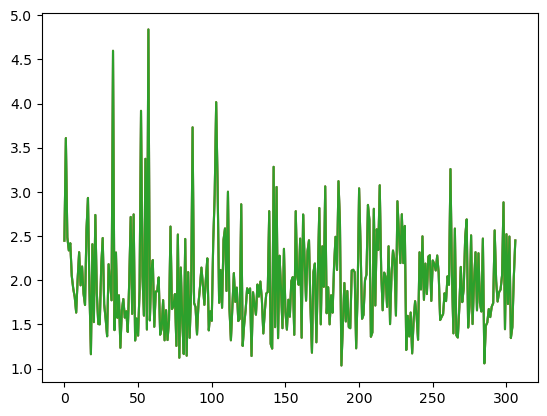

In [ ]:
%matplotlib inline
plt.plot(mse2)
plt.show()

In [3]:
config = {
    # fixed but maybe change...
    'batch_size': 2000,
    'workers': 6,
    'init_lr': 1e-10,
    'base_lr': 0.0005,
    'context_points': 32,
    'target_points': 1,
    'd_model': 100,
    'd_qk': 100,
    'd_v': 100,
    'd_ff': 400,
    'n_heads': 1,
    'enc_layers': 1,
    'dec_layers': 1,
    'global_self_attn': 'full',
    'local_self_attn': 'full',
    'global_cross_attn': 'full',
    'local_cross_attn': 'full',
    'no_val': False,
    'no_time': False,
    'no_space': False,
    'no_given': False,

    # directly set parameters
    'gpus': [0],
    # 'gpus':None,
    'strategy': 'dp',
    "time_resolution": 1,
    "start_token_len": 0,
    "attn_factor": 5,
    "dropout_emb": 0.2,
    "dropout_attn_out": 0,
    "dropout_attn_matrix": 0,
    "dropout_qkv": 0,
    "dropout_ff": 0.3,
    "pos_emb_type": 'abs',
    "no_final_norm": False,
    "performer_kernel": 'relu',
    "performer_redraw_interval": 100,
    "attn_time_windows": 1,
    "use_shifted_time_windows": False,
    "norm": 'batch',
    "activation": 'gelu',
    "warmup_steps": 0,
    "decay_factor": 0.25,
    "initial_downsample_convs": 0,
    "intermediate_downsample_convs": 0,
    "embed_method": 'spatio-temporal',
    "l2_coeff": 0.000001,
    "loss": 'mse',
    "class_loss_imp": 0.1,
    "recon_loss_imp": 0,
    "time_emb_dim": 3,
    "null_value": None,
    "pad_value": None,
    "linear_window": 0,
    "use_revin": False,
    "linear_shared_weights": False,
    "use_seasonal_decomp": False,
    "recon_mask_skip_all": 1,
    "recon_mask_max_seq_len": 5,
    "recon_mask_drop_seq": 0.2,
    "recon_mask_drop_standard": 0.1,
    "recon_mask_drop_full": 0.05,
    "grad_clip_norm": 0.0,
    "accumulate": 1,
    "limit_val_batches": 1.0,
    "max_epochs": 10,
    "val_check_interval": 1.0,
}

In [46]:
data.shape

(307100, 5)

In [47]:
data.shape

(307100, 5)

In [48]:
# error calculations
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
def smape(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))
def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))
def mse(y_true, y_pred):
    return np.mean(np.square(y_true - y_pred))
    

In [49]:
naive_forcast = data[1:,:]
mean_forcast = np.mean(data[:-1,:], axis=0)
#brodcast mean to be the same shape as the data
mean_forcast = np.broadcast_to(mean_forcast, (data.shape[0]-1, data.shape[1]))

print("Mape")
print(f"Naive: {mape(data[:-1,:], naive_forcast)}")
print(f"Mean: {mape(data[:-1,:], mean_forcast)}")
print("Smape")
print(f"Naive: {smape(data[:-1,:], naive_forcast)}")
print(f"Mean: {smape(data[:-1,:], mean_forcast)}")
print("Mae")
print(f"Naive: {mae(data[:-1,:], naive_forcast)}")
print(f"Mean: {mae(data[:-1,:], mean_forcast)}")
print("Mse")
print(f"Naive: {mse(data[:-1,:], naive_forcast)}")
print(f"Mean: {mse(data[:-1,:], mean_forcast)}")

Mape
Naive: 1032.2733993029972
Mean: 2972.78621432698
Smape
Naive: 585.1610288915779
Mean: 524.8671501546206
Mae
Naive: 0.9079976654937072
Mean: 0.7252794664220789
Mse
Naive: 1.8773334657974023
Mean: 1.2156299943645663


In [51]:

# mape = np.mean(np.mean(np.abs(error / data[:-1,:]), axis=0))
# mean_mape = np.mean(np.mean(np.abs(mean_forcast_error / data[:-1,:]), axis=0))
# print(mape)
# smape = np.mean(np.mean(np.abs(error) / (np.abs(data[:-1,:]) + np.abs(naive_forcast)), axis=0))
# print(smape)
# mse = np.mean(np.mean(np.square(error), axis=0))
# print(mse)

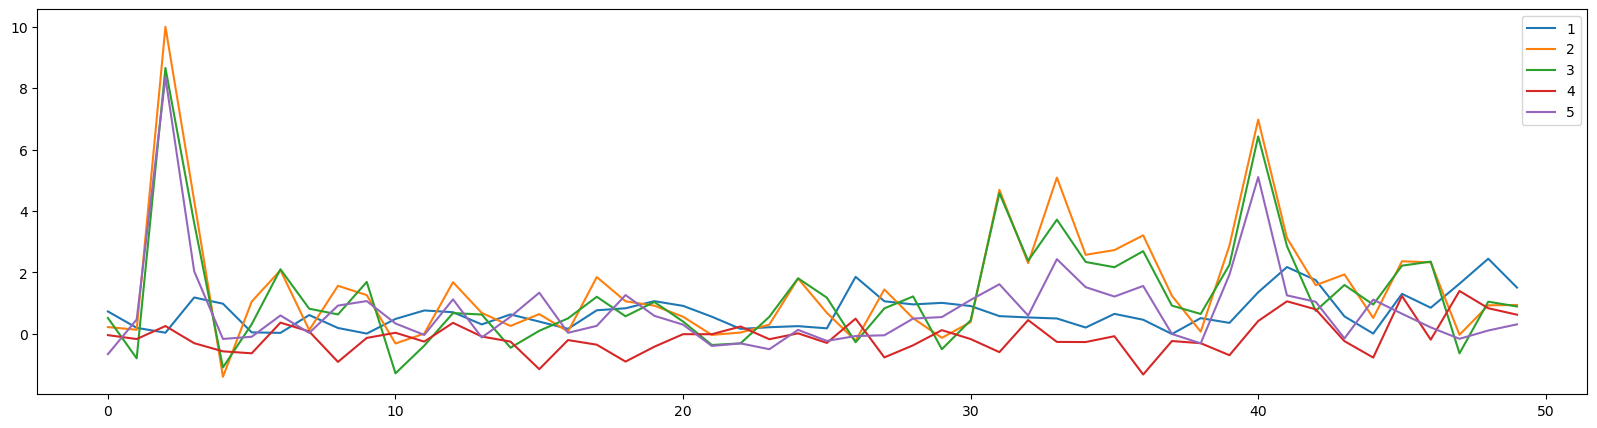

In [52]:
%matplotlib inline
plt.figure(figsize=(20, 5))
plt.plot(data[100:150,:])
plt.legend(PLOT_VAR_NAMES);

In [ ]:
data.shape

(307200, 5)